In [329]:
import pprint
import os
import copy
import glob
import math

import numpy as np
import scipy.spatial.transform
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

from PIL import Image
import torch
import torchvision.utils
%matplotlib inline

# from im2scene import config
import im2scene
import im2scene.config
import im2scene.checkpoints
import im2scene.giraffe.models
import im2scene.giraffe.models.decoder
import im2scene.discriminator.conv 
import im2scene.giraffe.models.bounding_box_generator
import im2scene.giraffe.models.neural_renderer
import im2scene.giraffe.models.generator
import im2scene.giraffe.rendering
from im2scene.common import interpolate_sphere

pp = pprint.PrettyPrinter(indent=0)

In [5]:
cfg = im2scene.config.load_config(
        "configs/64res/carlacarsv2_64.yaml",
        'configs/default.yaml')
# cfg["method"] => giraffe
pp.pprint(cfg["model"])
pp.pprint(cfg["data"])
# pp.pprint(cfg["test"])
# pp.pprint(cfg["training"])
# pp.pprint(cfg["method"])

{'background_generator': 'simple',
'background_generator_kwargs': {'downscale_p_by': 12,
                               'hidden_size': 64,
                               'n_blocks': 4,
                               'skips': []},
'bounding_box_generator': 'simple',
'bounding_box_generator_kwargs': {'rotation_range': [0.0, 1.0],
                                 'scale_range_max': [1.0, 1.0, 1.0],
                                 'scale_range_min': [1.0, 1.0, 1.0],
                                 'translation_range_max': [2.0, 2.0, 0.0],
                                 'translation_range_min': [-2.0, -2.0, 0.0]},
'decoder': 'simple',
'decoder_kwargs': {},
'discriminator': 'dc',
'discriminator_kwargs': {},
'generator': 'simple',
'generator_kwargs': {'backround_rotation_range': [0.0, 1.0],
                    'depth_range': [0.5, 10.0],
                    'fov': 90,
                    'range_radius': [2.8, 5.0],
                    'range_u': [0, 1],
                    'range_v': [0.0

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

This is what the line
`model = config.get_model(cfg, device=device, len_dataset=0)`
does in `render.py`.
It sets up all model components. Loading of weights is done elsewhere.

In [6]:
z_dim = 256
decoder_kwargs = {} # rgb_out_dim=128
decoder = im2scene.giraffe.models.decoder.Decoder(
    z_dim=z_dim, **decoder_kwargs
)

img_size = 64
discriminator_kwargs = {} # img_size=64
discriminator = im2scene.discriminator.conv.DCDiscriminator(
    img_size=img_size, **discriminator_kwargs
)

z_dim_bg = 128
background_generator_kwargs = {
    'hidden_size': 64,
    'n_blocks': 4,
    'downscale_p_by': 12,
    'skips': [],
} # rgb_out_dim=128
bg_generator = im2scene.giraffe.models.decoder.Decoder(
    z_dim=z_dim_bg, **background_generator_kwargs
)
bounding_box_generator_kwargs = {
    'rotation_range': [0.0, 1.0],
    'scale_range_max': [1.0, 1.0, 1.0],
    'scale_range_min': [1.0, 1.0, 1.0],
    'translation_range_max': [2.0, 2.0, 0.0],
    'translation_range_min': [-2.0, -2.0, 0.0]
}
bbox_generator = im2scene.giraffe.models.bounding_box_generator.BoundingBoxGenerator(
    z_dim=z_dim, **bounding_box_generator_kwargs
)

neural_renderer_kwargs = {} # n_feat=128, input_dim=128
neural_renderer = im2scene.giraffe.models.neural_renderer.NeuralRenderer(
    z_dim=z_dim, img_size=img_size, **neural_renderer_kwargs
)

generator_kwargs = {
    'backround_rotation_range': [0.0, 1.0],
    'depth_range': [0.5, 10.0],
    'fov': 90,
    'range_radius': [2.8, 5.0],
    'range_u': [0, 1],
    'range_v': [0.066987, 0.283058]
} # cars256 use 'fov': 10, 'range_v': [0.41667, 0.5]
generator = im2scene.giraffe.models.generator.Generator(
    device,
    z_dim=z_dim,
    z_dim_bg=z_dim_bg,
    decoder=decoder,
    background_generator=bg_generator,
    bounding_box_generator=bbox_generator,
    neural_renderer=neural_renderer,
    **generator_kwargs
)

generator_test = copy.deepcopy(generator)

model = im2scene.giraffe.models.GIRAFFE(
    device=device,
    discriminator=discriminator,
    generator=generator,
    generator_test=generator_test,
)

In `render.py`

```
checkpoint_io = CheckpointIO(out_dir, model=model)
checkpoint_io.load(cfg['test']['model_file'])
```

Applies `torch.load()` to load trained weights to the model.
Here we will load our local copy of the pretrained cars256 model corresponding to the cars256 configuration.

Author pretrained cars256 model has been trained for 139 epochs, 580000 iterations (5 days?).

My cars64 model has been trained for 1 day (24 hours) on 1 GPU, 16 GB memory, 4 CPUs. This gives 33 epochs, 144360 iterations.

In [7]:
local_dir = "out/carlaCarsV2_64"
checkpoint_io = im2scene.checkpoints.CheckpointIO(
    local_dir, model=model
)
filename = "model_best.pt"
scalars = checkpoint_io.load(filename)
# pp.pprint(scalars)

out/carlaCarsV2_64/model_best.pt
=> Loading checkpoint from local file...


### Extra

In [11]:
print(*scalars.keys())
print(*scalars['optimizer'].keys())
# pp.pprint(scalars)
# scalars['optimizer']['param_groups']

epoch_it it loss_val_best optimizer optimizer_d
state param_groups


### Render interpolation

In [12]:
model.eval()
gen = model.generator_test
gen.eval() # renderer.generator
None

In [13]:
# body of renderer.render_interpolation()

# sample temperature; only used for visualiations
sample_tmp = 0.65
batch_size = 1
n_samples = 6
n_steps = 32

n_boxes = gen.bounding_box_generator.n_boxes

z_shape_obj_1, z_app_obj_1, z_shape_bg_1, z_app_bg_1 = \
    gen.get_latent_codes(batch_size, tmp=sample_tmp)

z_i = [
    gen.sample_z(
        z_app_obj_1.shape,
        tmp=sample_tmp) for j in range(n_samples)
]

bg_rotation = gen.get_random_bg_rotation(batch_size)
camera_matrices = gen.get_camera(batch_size=batch_size)

if n_boxes == 1:
    t_val = [[0.5, 0.5, 0.5]]
transformations = gen.get_transformations(
    [[0., 0., 0.] for i in range(n_boxes)],
    t_val,
    [0.5 for i in range(n_boxes)],
    batch_size
)

out = []
for j in range(n_samples):
    z_i1 = z_i[j]
    z_i2 = z_i[(j+1) % (n_samples)]
    for step in range(n_steps):
        w = step * 1.0 / ((n_steps) - 1)
        z_ii = interpolate_sphere(z_i1, z_i2, w)
        latent_codes = [z_shape_obj_1, z_ii, z_shape_bg_1,
                        z_app_bg_1]
        with torch.no_grad():
            out_i = gen(batch_size, latent_codes, camera_matrices,
                        transformations, bg_rotation, mode='val')
        out.append(out_i.cpu())
# out has shape (n_steps*n_samples, batch_size, channels, H, W)
out = torch.stack(out)

"""Saving process looks like this:

out_folder = join(img_out_path, 'interpolate_%s' % mode)
makedirs(out_folder, exist_ok=True)
self.save_video_and_images(
    out, out_folder, name='interpolate_%s' % mode,
    is_full_rotation=True)
"""
out.shape

torch.Size([192, 1, 3, 64, 64])

Plot the style interpolation of one car in a batch.

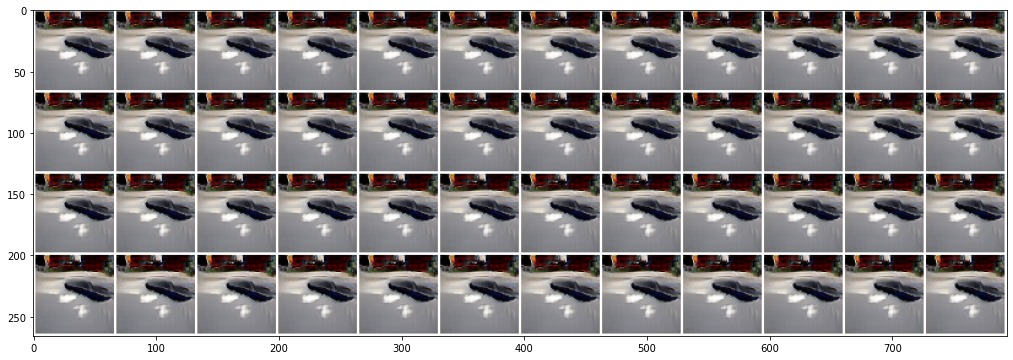

In [14]:
%matplotlib inline
imgs = out
img_n_steps = 48
n_steps, batch_size = imgs.shape[:2]

# select img_n_steps points in range(n_steps*n_samples)
idx_paper = np.linspace(
    0, n_steps - n_steps // img_n_steps, img_n_steps
).astype(np.int)

# get the first batch
_imgs = imgs[idx_paper, 0]
img_grid = torchvision.utils.make_grid(
    _imgs, nrow=img_n_steps // 4, pad_value=1.
)
plt.figure(figsize=(20,6))
plt.imshow(img_grid.numpy().transpose(1,2,0))
None

### What does GIRAFFE model dataflow look like?

`GIRAFFE` => `DCDiscriminator`, `Generator`, test copy of `Generator`.

`GIRAFFE.forward()` calls `Generator.forward()`

`Generator` => `Decoder`, `Decoder` for background, `BoundingBoxGenerator` and `NeuralRenderer`.

`Generator.forward()` does:

1. `self.get_latent_codes()` samples latent variables from normal distribution if they have not been passed as argument.
2. similarly sample camera matrices, tranformations and rotations if they have not been passed as arguments.
3. `self.volumn_render_image()`
4. `NeuralRenderer.forward()`

`Generator.volume_render_image()` does:

1. finds pixel and origin coordinates in world reference. Computes ray vector.
2. computes step sizes `di` for sampling along ray and integration of ray.
3. for each entity (foreground objects and background) do
    - `self.get_evaluation_points()` to get ray and point coordinates to sample entity color and density from.
    - `Decoder.forward()` to get sample entity color and density.
4. If `self.sample_object_existance` is true (not in our case), then use `self.get_object_existance()` ...etc to make some objects invisible for variable number of objects generation.
5. `self.composite_function()` to combine color and density from entities.
6. `self.calc_volume_weights()` to integrate color and density.
7. finishing tasks of creating hidden 2D image feature to send to `NeuralRenderer`.

Given the output of `Generator.volume_render_image()`, `NeuralRenderer.forward()` does:

1. `self.conv_in` is an identity map
2. `self.use_rgb_skip` is true so use so do compositions of the operations
    - `Conv2d(X, 3, kernel_size=3, stride=1, padding=1)`. If this is done in the intermediate layers than add it to the output as residual.
    - bilinear upsampling by factor 2 and blur.
    - `Conv2d(X, X / 2, kernel_size=3, stride=1, padding=1)`.
    - Leaky ReLU activations with 0.2 leak.
3. final sigmoid activation

`im2scene.common.arange_pixels()` produces pixel coordinates as (16x16, 2) array.  
`im2scene.common.image_points_to_world()` projects pixel coordinates to world coordinates based on camera matrix and world matrix. This uses `transform_to_world()`.


In [17]:
model.eval()
gen = model.generator_test
gen.eval() # renderer.generator
None

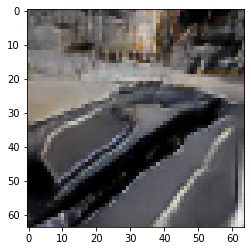

In [44]:
# calling the Generator
batch_size = 1
# out has shape (1, 3, 256, 256)
out = gen(batch_size)

img = out[0]
plt.figure(figsize=(4,4))
plt.imshow(img.cpu().detach().numpy().transpose(1,2,0))
None

In [30]:
latent_codes = gen.get_latent_codes(batch_size)

In [31]:
camera_matrices = gen.get_random_camera(batch_size)

In [32]:
transformations = gen.get_random_transformations(batch_size)

In [33]:
bg_rotation = gen.get_random_bg_rotation(batch_size)

In [34]:
it = 0
# rgb_v has shape (batch size, 256, 16, 16)
rgb_v = gen.volume_render_image(
    latent_codes, camera_matrices,
    transformations, bg_rotation,
    mode="val", it=it,
    not_render_background=False,
    only_render_background=False)

In [35]:
# out has shape (1, 3, 256, 256)
out = gen.neural_renderer(rgb_v)

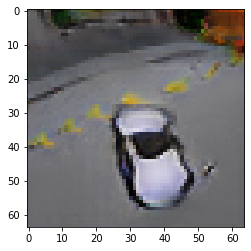

In [36]:
img = out[0]
plt.figure(figsize=(4,4))
plt.imshow(img.cpu().detach().numpy().transpose(1,2,0))
None

### More detailed breakdown of model dataflow

`BoundingBoxGenerator` computes the what?

- Pixel coordinates are normalized [-1,1].
`Generator.camera_matrix` is a camera matrix fixed for all images that converts image coordinates to 3D coordinates in camera referece point. 

`Generator.forward()` does:

1. `self.get_latent_codes()` samples latent variables from normal distribution if they have not been passed as argument.

2. `self.get_random_camera()` calls `get_random_pose()` to obtain pose matrix $[R|t]$ mapping 3D coordinates with object center reference point to camera reference point, where the camera is placed on a randomized location on a sphere with randomized radius facing the object.
   Return camera matrix and pose matrix.
   
   Question: what's the metric used for radius??

3. `self.get_random_transformations()` calls `BoundingBoxGenerator.forward()`.

4. `self.get_random_bg_rotation()` computes `R` which is the rotation matrix for rotating the background about the local z axis.

5. `self.volumn_render_image()`

6. `NeuralRenderer.forward()`

`BoundingBoxGenerator.forward()` calls `self.get_random_offset()` to produce `s`, `t`, `R`.  

Question: what is the metric used for scale, translation?  

Question: the bounding box center at $t = (x,y,z)$ or somewhere else?

- `s` is the $(x,y,z)$ scaling of the bounding box.
  It is controlled by YAML config `scale_range_min`, `scale_range_max` in
  `model.bounding_box_generator_kwargs`.

- `t` is the $(x,y,z)$ translation of the bounding box.
  Translation is controlled by YAML config `translation_range_min`, `translation_range_max` in
  `model.bounding_box_generator_kwargs`.
  At this point `s`, `t` are used to check collision and new `t` is generated if necessary.

- `R` is the rotation matrix for rotating the bounding box about the local z axis.

`Generator.volume_render_image()` does:

The output is a tensor `rgb_v` of shape (256,W=16,W=16).

`model.generator_kwargs` in YAML config has

- `resolution_vol`, alternative W for `rgb_v`.
- `n_ray_samples` is the number of samples per ray, or number of `dt` steps.
- `depth_range` defines the nearest and furthest depth from the ray to sample from.

1. use `im2scene.common.arange_pixels()` to produce pixel coordinates as (16x16, 2) array normalized to $[-1, 1]^2$.

2. use `im2scene.common.image_points_to_world()` to map pixel coordinates to world coordinates.

    This operation maps pixel coordinates to parallel pane 1 m away from the camera origin.
    I believe the radius and translation coordinates are with respect to this 1 m.

3. use `im2scene.common.origin_to_world()` to map camera origin to world coordinates.

4. computes step sizes `di` for sampling along ray and integration of ray in "ray depth" coordinates.

4. For each entity, `self.get_evaluation_points()` calls `self.transform_points_to_box()` to produce 3D points and directions out of the camera in the reference frame of the entity to sample color and density.

5. In the same for loop `Decoder.forward()` to get entity color and density over the coordinates corresponding to the entity.

6. remaining steps are explained in earlier cell.

In [184]:
# run this first
model.eval()
gen = model.generator_test
gen.eval() # renderer.generator
None

In [185]:
# this is what the camera matrix looks like
print(gen.camera_matrix)

tensor([[[1., 0., 0., -0.],
         [0., 1., 0., -0.],
         [0., 0., 1., -0.],
         [0., 0., 0., 1.]]], device='cuda:0')


(16, 256, 64)

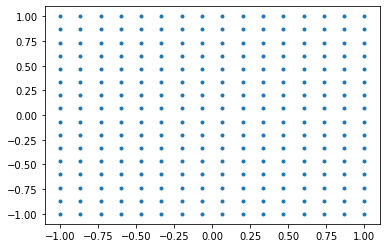

In [186]:
%matplotlib inline
# collect a grid of pixels
# pixels has shape (batch_size=1, res*res, 2)
res = gen.resolution_vol
n_points = res * res
n_steps = gen.n_ray_samples
_, pixels = im2scene.common.arange_pixels((res, res))
pixels = pixels
pixels[..., -1] *= -1. # why?
plt.scatter(*pixels[0].T, marker=".")
pixels = pixels.to(device)
res, n_points, n_steps

In [187]:
# get the camera and world matrix
is_random = False
if is_random:
    camera_mat, world_mat = gen.get_random_camera(batch_size=1, to_device=True)
else:
    camera_mat, world_mat = gen.get_camera(batch_size=1, to_device=True)

In [188]:
# call this cell to use a different camera matrix
fov = 40
camera_mat = im2scene.camera.get_camera_mat(fov=fov).to(device)
camera_mat

tensor([[[0.3640, 0.0000, 0.0000, -0.0000],
         [0.0000, 0.3640, 0.0000, -0.0000],
         [0.0000, 0.0000, 1.0000, -0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000]]], device='cuda:0')

<IPython.core.display.Javascript object>


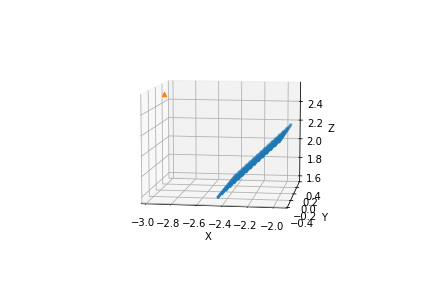

(torch.Size([1, 256, 3]), torch.Size([1, 256, 3]))

In [189]:
%matplotlib notebook
# project the grid of pixels to the world
# pixels_world has shape (batch_size=1, res*res, 3)
pixels_world = im2scene.common.image_points_to_world(pixels, camera_mat, world_mat)

# get the origin of the camera in world space
# camera_world has shape (batch_size=1, res*res, 3)
camera_world = im2scene.common.origin_to_world(n_points, camera_mat=camera_mat, world_mat=world_mat)

fig = plt.figure()#figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(*pixels_world.cpu()[0].T, marker=".")
ax.scatter(*camera_world.cpu()[0, 0].T, marker="^")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
pixels_world.shape, camera_world.shape

In [190]:
# compute step sizes
depth_range = gen.depth_range
di = depth_range[0] + \
        torch.linspace(0., 1., steps=n_steps).reshape(1, 1, -1) * (
            depth_range[1] - depth_range[0])
# di has shape (batch_size=1, res*res, n_ray_samples)
di = di.repeat(1, n_points, 1).to(device)
di.shape, depth_range

(torch.Size([1, 256, 64]), [0.5, 10.0])

In [191]:
# get latent shape and appearance codes for object and background
# z_shape_obj, z_app_obj has shape (batch_size=1, n_objects=1, 256)
# z_shape_bg, z_app_bg has shape (batch_size=1, 128)
latent_codes = gen.get_latent_codes(1)
z_shape_obj, z_app_obj, z_shape_bg, z_app_bg = latent_codes
z_shape_obj.shape, z_app_obj.shape, z_shape_bg.shape, z_app_bg.shape

(torch.Size([1, 1, 256]),
 torch.Size([1, 1, 256]),
 torch.Size([1, 128]),
 torch.Size([1, 128]))

In [192]:
# get random transformation tuples (s, t, R)
# s, t has shape (batch_size=1, n_objects=1, 3)
transformations = gen.get_random_transformations(1)
s, t, R = transformations
s.shape, t.shape, R.shape

(torch.Size([1, 1, 3]), torch.Size([1, 1, 3]), torch.Size([1, 1, 3, 3]))

In [193]:
s[0,0], t[0,0], R[0,0]

(tensor([1., 1., 1.], device='cuda:0'),
 tensor([ 0.5874, -0.4272,  0.0000], device='cuda:0'),
 tensor([[ 0.9995, -0.0330,  0.0000],
         [ 0.0330,  0.9995,  0.0000],
         [ 0.0000,  0.0000,  1.0000]], device='cuda:0'))

<IPython.core.display.Javascript object>


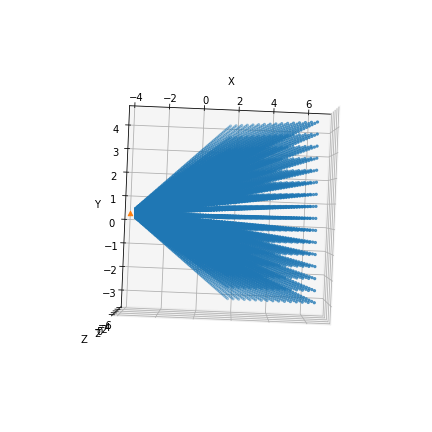

(torch.Size([1, 16384, 3]), torch.Size([1, 16384, 3]))

In [194]:
%matplotlib notebook
# p_i, r_i has shape (batch_size=1, ?, 3)
p_i, r_i = gen.get_evaluation_points(
        pixels_world, camera_world, di, transformations, 0)
_camera_world, _ = gen.get_evaluation_points(
        camera_world, camera_world, di, transformations, 0)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(*p_i.cpu()[0].T, marker=".")
ax.scatter(*_camera_world.cpu()[0, 0].T, marker="^")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
p_i.shape, r_i.shape

How does `Generator.get_evaluation_points()` work?
Rigid transformation is applied to 3D points `pixels_world`
using `Generator.transform_points_to_box()` this way:

```
bb_s, bb_t, bb_R = transformations
p_box = (bb_R[:, 0] @ (p - bb_t[:, 0].unsqueeze(1)
                             ).permute(0, 2, 1)).permute(
    0, 2, 1) / bb_s[:, 0].unsqueeze(1)
```

<IPython.core.display.Javascript object>


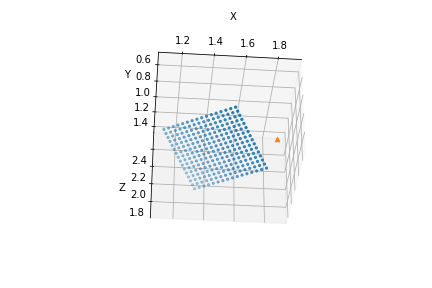

(torch.Size([1, 256, 3]), torch.Size([1, 256, 3]))

In [172]:
%matplotlib notebook

pixels_world_i = gen.transform_points_to_box(
        pixels_world, transformations, 0)
camera_world_i = gen.transform_points_to_box(
        camera_world, transformations, 0)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*pixels_world_i.cpu()[0].T, marker=".")
ax.scatter(*camera_world_i.cpu()[0, 0].T, marker="^")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
pixels_world.shape, camera_world.shape

Scratch work

In [ ]:
x = np.linspace(0, 1, 100)
phi = np.arccos(1 - 2*x)
plt.plot(x, phi)

In [ ]:
(1 - math.cos((5/14)*math.pi))/2, (1 - math.cos((1/6)*math.pi))/2

### Coming up with good 3D sample points

In [479]:
# run this first
model.eval()
gen = model.generator_test
gen.eval() # renderer.generator
None

In [498]:
# get random transformation tuples (s, t, R)
# s, t has shape (batch_size=1, n_objects=1, 3)
is_random = False
if is_random:
    transformations = gen.get_random_transformations(1)
else:
    transformations = gen.get_transformations(batch_size=1)
s, t, R = transformations

transformations = (
    s, torch.tensor([[[-0.5, -0.5, 0]]], device=device, dtype=torch.float), R
)
transformations = (
    s, torch.tensor([[[0., 0., 0]]], device=device, dtype=torch.float), R
)

s, t, R = transformations
s.shape, t.shape, R.shape

(torch.Size([1, 1, 3]), torch.Size([1, 1, 3]), torch.Size([1, 1, 3, 3]))

In [499]:
s[0,0], t[0,0], R[0,0]

(tensor([1., 1., 1.], device='cuda:0'),
 tensor([0., 0., 0.], device='cuda:0'),
 tensor([[-1.0000e+00, -1.2246e-16,  0.0000e+00],
         [ 1.2246e-16, -1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0'))

(16, 256, 64)

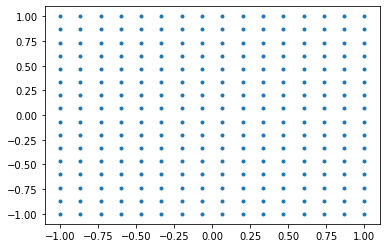

In [500]:
%matplotlib inline
# collect a grid of pixels
# pixels has shape (batch_size=1, res*res, 2)
res = gen.resolution_vol
n_points = res * res
n_steps = gen.n_ray_samples
_, pixels = im2scene.common.arange_pixels((res, res))
pixels = pixels
pixels[..., -1] *= -1. # why?
plt.scatter(*pixels[0].T, marker=".")
pixels = pixels.to(device)
res, n_points, n_steps

In [501]:
# get the camera and world matrix
range_u, range_v, range_radius = gen.range_u, gen.range_v, gen.range_radius
range_v = [0.283058, 0.283058]
# range_v = [0.066987, 0.066987]
# range_radius = [5, 6]
range_radius = [5, 5]
print(range_u, range_v, range_radius)

is_random = False
if is_random:
    world_mat = im2scene.camera.get_random_pose(range_u, range_v, range_radius, 1).to(device)
else:
    world_mat = im2scene.camera.get_middle_pose(range_u, range_v, range_radius, 1).to(device)
fov = 35
camera_mat = im2scene.camera.get_camera_mat(fov=fov).to(device)
camera_mat, world_mat

[0, 1] [0.283058, 0.283058] [5, 5]


(tensor([[[0.3153, 0.0000, 0.0000, -0.0000],
          [0.0000, 0.3153, 0.0000, -0.0000],
          [0.0000, 0.0000, 1.0000, -0.0000],
          [0.0000, 0.0000, 0.0000, 1.0000]]], device='cuda:0'),
 tensor([[[-1.2246e-16,  4.3388e-01, -9.0097e-01, -4.5048e+00],
          [-1.0000e+00, -5.3135e-17,  1.1034e-16,  5.5168e-16],
          [ 0.0000e+00,  9.0097e-01,  4.3388e-01,  2.1694e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
        device='cuda:0'))

<IPython.core.display.Javascript object>


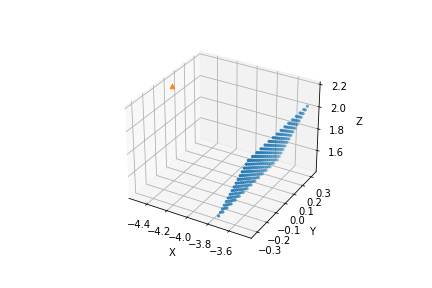

(torch.Size([1, 256, 3]), torch.Size([1, 256, 3]), tensor(5., device='cuda:0'))

In [502]:
%matplotlib notebook
# project the grid of pixels to the world
# pixels_world has shape (batch_size=1, res*res, 3)
pixels_world = im2scene.common.image_points_to_world(pixels, camera_mat, world_mat)

# get the origin of the camera in world space
# camera_world has shape (batch_size=1, res*res, 3)
camera_world = im2scene.common.origin_to_world(n_points, camera_mat=camera_mat, world_mat=world_mat)

fig = plt.figure()#figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(*pixels_world.cpu()[0].T, marker=".")
ax.scatter(*camera_world.cpu()[0, 0].T, marker="^")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
pixels_world.shape, camera_world.shape, torch.norm(camera_world[0,0])

<IPython.core.display.Javascript object>


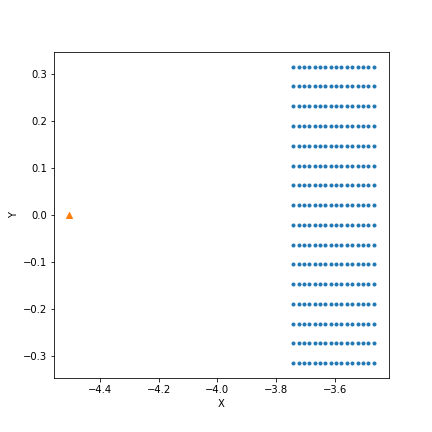

Text(0, 0.5, 'Y')

In [503]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(*pixels_world.cpu()[0, :, :2].T, marker=".")
ax.scatter(*camera_world.cpu()[0, 0, :2].T, marker="^")
ax.set_xlabel('X')
ax.set_ylabel('Y')

In [504]:
# compute step sizes
depth_range = gen.depth_range
depth_range = [1.5, 7]
di = depth_range[0] + \
        torch.linspace(0., 1., steps=n_steps).reshape(1, 1, -1) * (
            depth_range[1] - depth_range[0])
# di has shape (batch_size=1, res*res, n_ray_samples)
di = di.repeat(1, n_points, 1).to(device)
di.shape, depth_range

(torch.Size([1, 256, 64]), [1.5, 7])

<IPython.core.display.Javascript object>


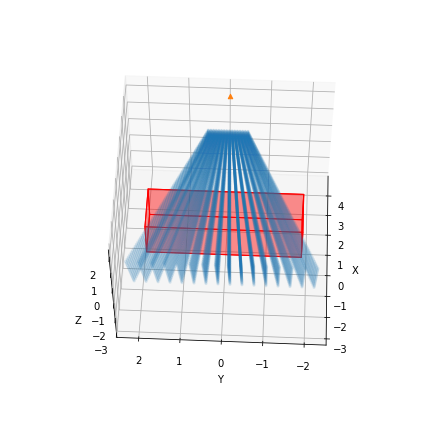

(torch.Size([1, 16384, 3]), torch.Size([1, 16384, 3]))

In [509]:
# this visualization is accurate only because it assumes no scaling

%matplotlib notebook
# p_i, r_i has shape (batch_size=1, ?, 3)
p_i, r_i = gen.get_evaluation_points(
        pixels_world, camera_world, di, transformations, 0)
camera_world_i = gen.transform_points_to_box(
        camera_world, transformations, 0)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(*p_i.cpu()[0].T, marker=".", alpha=0.1)
ax.scatter(*camera_world_i.cpu()[0, 0].T, marker="^")

directions = np.array([[-1, -1, -1],
                  [1, -1, -1 ],
                  [1, 1, -1],
                  [-1, 1, -1],
                  [-1, -1, 1],
                  [1, -1, 1 ],
                  [1, 1, 1],
                  [-1, 1, 1]])

dimensions = np.array([0.9, 1.85, 0.8])

Z = np.zeros((8,3))
for i in range(8): Z[i,:] = directions[i,:]*dimensions
r = scipy.spatial.transform.Rotation.from_rotvec(np.pi/2*0 * np.array([0, 0, 1]))
Z = r.apply(Z)

# ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])
# list of sides' polygons of figure
verts = [[Z[0],Z[1],Z[2],Z[3]],
 [Z[4],Z[5],Z[6],Z[7]], 
 [Z[0],Z[1],Z[5],Z[4]], 
 [Z[2],Z[3],Z[7],Z[6]], 
 [Z[1],Z[2],Z[6],Z[5]],
 [Z[4],Z[7],Z[3],Z[0]]]

ax.add_collection3d(Poly3DCollection(verts, 
 facecolors='r', linewidths=1, edgecolors='r', alpha=.25))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
p_i.shape, r_i.shape

<IPython.core.display.Javascript object>


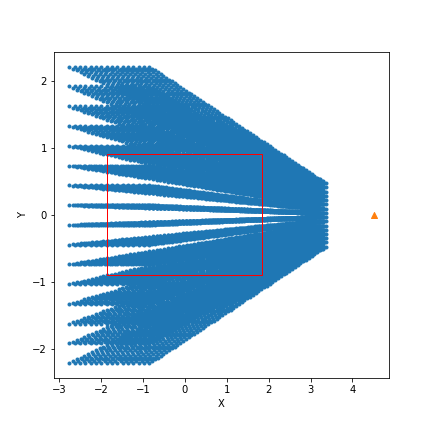

Text(0, 0.5, 'Y')

In [508]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(*p_i.cpu()[0, :, :2].T, marker=".")
ax.scatter(*camera_world_i.cpu()[0, 0, :2].T, marker="^")

# Audi A2 has dimensions (3.70 m, 1.79 m, 1.55 m)

theta, disp = np.pi/2, np.array([0.5, 0.5])
theta, disp = np.pi/2, np.array([0., 0.])
vertices = np.array([
    [0.9, 1.85],
    [0.9, -1.85],
    [-0.9, -1.85],
    [-0.9, 1.85],
])
M = np.array([
    [ np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]])
vertices = (vertices @ M.T) + disp

patch = patches.Polygon(vertices, fill=False, color='r')
ax.add_patch(patch)

ax.set_xlabel('X')
ax.set_ylabel('Y')

In [364]:
1.8 / 2, 3.7 / 2, 1.6/2

(0.9, 1.85, 0.8)

<IPython.core.display.Javascript object>


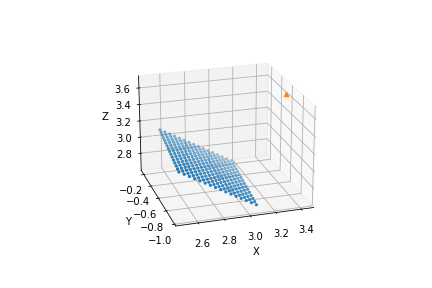

(torch.Size([1, 256, 3]), torch.Size([1, 256, 3]))

In [205]:
%matplotlib notebook

pixels_world_i = gen.transform_points_to_box(
        pixels_world, transformations, 0)
camera_world_i = gen.transform_points_to_box(
        camera_world, transformations, 0)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*pixels_world_i.cpu()[0].T, marker=".")
ax.scatter(*camera_world_i.cpu()[0, 0].T, marker="^")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
pixels_world.shape, camera_world.shape